# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import breakout_utils
from parallelEnv import parallelEnv

%matplotlib inline

In [2]:
device = breakout_utils.device
print("using device: ",device)

using device:  cuda:0


In [3]:
env = gym.make('Breakout-v0')
print("List of available actions: ", env.unwrapped.get_action_meanings())

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT']


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel


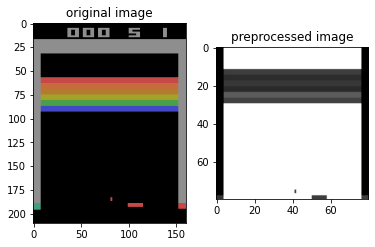

In [4]:
# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(breakout_utils.preprocess_single(frame), cmap='Greys')
plt.show()



# Policy

In [5]:
# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
        self.conv1 = nn.Conv2d(2, 16, kernel_size=6, stride=2)
        self.size=16*38*38
        
        # 1 fully connected layer
        self.fc = nn.Linear(self.size, 3)
        
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
        # flatten the tensor
        x = x.view(-1,self.size)
#         print(F.softmax(self.fc(x), dim=1))
        return F.softmax(self.fc(x), dim=1)

# use your own policy!
policy=Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress

In [6]:
breakout_utils.play(env, policy, time=400) 
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

# Function Definitions
Here you will define key functions for training. 

In [7]:
def clipped_surrogate(policy, old_probs, states, actions, rewards,
                      discount = 0.995, epsilon=0.1, beta=0.01):

    ########
    ## 
    ## WRITE YOUR OWN CODE HERE
    ##
    ########
    
    actions = torch.tensor(actions, dtype=torch.int8, device=device)

    # convert states to policy (or probability)
    new_probs = breakout_utils.states_to_prob(policy, states)
    new_probs = torch.where(actions == breakout_utils.RIGHT, new_probs, 1.0-new_probs)

    # include a regularization term
    # this steers new_policy towards 0.5
    # prevents policy to become exactly 0 or 1 helps exploration
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))

    return torch.mean(beta*entropy)


# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [8]:
# keep track of how long training takes
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 1000

# widget bar to display progress
!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()


envs = parallelEnv('PongDeterministic-v4', n=6)

discount_rate = .99
epsilon = 0.1
beta = .01
tmax = 50
SGD_epoch = 4

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = \
        breakout_utils.collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)


    # gradient ascent step
    for _ in range(SGD_epoch):
        
        # uncomment to utilize your own clipped function!
        # L = -clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)

        L = -breakout_utils.clipped_surrogate(policy, old_probs, states, actions, rewards,
                                          epsilon=epsilon, beta=beta)
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        del L
    
    # the clipping parameter reduces as time goes on
    epsilon*=.999
    
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()

torch.Size([50, 6]) torch.Size([50, 6, 3])


RuntimeError: The size of tensor a (6) must match the size of tensor b (3) at non-singleton dimension 2

In [ ]:
states =  torch.rand([50, 6, 2, 80, 80]).cuda()
# policy_input =  torch.rand([300, 2, 80, 80])
policy_input = states.view(-1,*states.shape[-3:])
# print(policy_input.shape)
# print(states.shape[:-3])
print(policy(policy_input).shape)
print(torch.argmax(policy(policy_input), dim=1).shape)
# policy(policy_input).view(states.shape[0], states.shape[1], 3).shape
torch.argmax(policy(policy_input), dim=1).view(states.shape[:-3]).shape

In [ ]:
prob = torch.rand([50, 6, 3])
prob = 

In [ ]:
breakout_utils.play(env, policy, time=500) 

In [ ]:
# save your policy!
torch.save(policy, 'PPO.policy')

# load policy if needed
# policy = torch.load('PPO.policy')

# try and test out the solution 
# make sure GPU is enabled, otherwise loading will fail
# (the PPO verion can win more often than not)!
#
# policy_solution = torch.load('PPO_solution.policy')
# breakout_utils.play(env, policy_solution, time=2000) 